In [60]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from pathlib import Path
from scipy.special import rel_entr, kl_div
from scipy.stats import wasserstein_distance

PARAMETERS = ['cpa', 'pwr1par', 'pwr2par', 'pwr1perr', 'pwr2perr'] 
PARAMETERS_MIN = np.array([100., 0.4, 0.4, 0.4, 0.4]) 
PARAMETERS_MAX = np.array([870., 1.7, 1.7, 2.3, 2.3]) 

In [61]:
print((3.49 / 10) * (10_000 * 2 + 10_000) / (60 * 60))

2.9083333333333337


## Relevant functions from utils.py
Can't just import utils since path to data is different than utils.py

In [62]:
def index_mcmc_runs(file_version):
    """Make a list of combinations for which we want to run MCMC."""
    if file_version == '2023':
        experiments = ['AMS02_H-PRL2021', 'PAMELA_H-ApJ2013', 'PAMELA_H-ApJL2018']
        dfs = []
        for experiment_name in experiments:
            filename = f'../../data/2023/{experiment_name}_heliosphere.dat'
            df = index_experiment_files(filename) 
            df['experiment_name'] = experiment_name
            df['filename_heliosphere'] = filename
            dfs.append(df)
        df = pd.concat(dfs, axis=0, ignore_index=0)

    elif file_version == '2024':
        filename = f'../../data/2024/yearly_heliosphere.dat'
        df = read_experiment_summary(filename)
        df['experiment_name'] = 'yearly'
        df['filename_heliosphere'] = filename

    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    return df

def read_experiment_summary(filename) -> pd.DataFrame:
    """
    Read .dat filename that describes experimental conditions during time intervals.
    """
    if '2023' in filename: file_version = '2023'
    elif '2024' in filename: file_version = '2024'
    else: raise ValueError(f"Unknown file_version {file_version}. Must be '2023' or '2024'.")

    if file_version == '2023':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std"
        df = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std'])
    
        # Parse interval
        df['beginning'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))
        df['ending'] = df.interval.apply(lambda x: pd.to_datetime(x.split('-')[0], format='%Y%m%d'))

    elif file_version == '2024':
        # Header reads "time interval; alpha avg; cmf avg; vspoles avg; alpha std; cmf std; vspoles std; polarity"
        df_full = pd.read_csv(filename, sep=' ', skiprows=1, names=['interval', 'alpha', 'cmf', 'vspoles', 'alpha_std', 'cmf_std', 'vspoles_std', 'polarity'])

        # only use the neg or neg,pos polarities column, and change all to be neg
        df = df_full[df_full['polarity'].str.contains('neg')].copy(deep=True)
        df['polarity'] = 'neg'

    return df

def index_experiment_files(filename)->pd.DataFrame:
    """Create list of experiments that need to be done. 
    Note this is only needed for file_version '2023'
    filename = f'../../data/2023/{EXPERIMENT_NAME}_heliosphere.dat'
    """
    df = read_experiment_summary(filename)
    # The datasets to be fitted are: PAMELA_H-ApJ2013, PAMELA_H-ApJL2018, and AMS02_H-PRL2021.
    # You should use the neg models for data files up to February 2015, and the pos models for data files from October 2013.
    # So, between October 2013 and February 2015, the data files should be fitted independently with both neg and pos models.
    # All PAMELA files are before February 2015, so only neg models for them.
    # For AMS02 files, 20130925-20131021.dat is the first file to be fitted with pos models, while 20150124-20150219.dat is the last file to be fitted with neg models.
    # 
    # For PAMELA_H-ApJL2018, the files 20130928-20131025.dat, 20131121-20131219.dat, and 20140115-20140211.dat should be fit independently with both neg and pos models.

    dfneg = df[df.beginning < pd.to_datetime('March 1 2015')].copy(deep=True)
    dfneg['polarity'] = 'neg'

    dfpos = df[df.ending >= pd.to_datetime('October 1 2013')].copy(deep=True)
    dfpos['polarity'] = 'pos'

    # rval = pd.concat([dfneg, dfpos], axis=0, ignore_index=True)
    rval = dfneg # Only fitting negative models for now.
    
    return rval

Implement distance metrics, including Gelman-Rubin statistic

In [63]:
def _as_array(x):
    """Get a float64 NumPy array from a pandas Series/array-like."""
    # Works for pandas Series (has .values) and plain np arrays/lists
    try:
        return np.asarray(x.values, dtype=float)
    except AttributeError:
        return np.asarray(x, dtype=float)

def _rhat_from_chains(chains_2d: np.ndarray,
                      ensure_ge1: bool = True,
                      return_details: bool = False):
    """
    Compute Gelman–Rubin R-hat from multiple chains following the 4-step description from 
    https://mystatisticsblog.blogspot.com/2019/04/gelman-rubin-convergence-criteria-for.html. 
    Assumes chains are already prepared (e.g., only second halves if that's your convention), 
    so that `chains_2d` has shape (m, n) with m = #chains and n = samples/chain.

    Steps implemented:
      1) (Warmup removal is assumed done before this function.)
      2) Per-chain mean & variance:  θ̄_j and σ²(θ_j)
      3) Mean-of-means θ̄̄, mean within-chain variance σ̄²(θ),
         variance of chain means σ²(θ̄)
         Then B_j = σ²(θ̄) − (1/n) σ̄²(θ)
      4) R̂ = sqrt( 1 + B_j / σ̄²(θ) )

    Also computes the classic equivalent:
      W = σ̄²(θ), B = n * σ²(θ̄),
      Var⁺ = ((n−1)/n) W + (B/n),
      R̂_classic = sqrt(Var⁺ / W)

    Args
    ----
    chains_2d : np.ndarray
        Shape (m, n): m chains, n samples per chain.
    ensure_ge1 : bool
        If True, clamp R-hat to be at least 1.0 (common practice).
    return_details : bool
        If True, return (rhat, details_dict). Otherwise return rhat (float).

    Returns
    -------
    rhat : float
    (optionally) details : dict with intermediate quantities
    """
    if chains_2d.ndim != 2:
        raise ValueError("chains_2d must have shape (m, n).")
    m, n = chains_2d.shape
    if m < 2 or n < 2:
        out = np.nan
        return (out, {}) if return_details else out

    # Step 2: per-chain means and variances (unbiased)
    theta_bar_j = chains_2d.mean(axis=1)             # θ̄_j
    sigma2_theta_j = chains_2d.var(axis=1, ddof=1)   # σ²(θ_j), unbiased

    # Step 3: across-chain aggregates
    theta_barbar = theta_bar_j.mean()                              # θ̄̄
    sigma2_bar_theta = sigma2_theta_j.mean()                       # σ̄²(θ) = W
    sigma2_theta_bar = theta_bar_j.var(ddof=1)                     # σ²(θ̄)
    B_j = sigma2_theta_bar - (sigma2_bar_theta / n)                # B_j

    # Step 4: scale reduction
    if sigma2_bar_theta <= 0:
        rhat = np.nan
    else:
        rhat = float(np.sqrt(1.0 + (B_j / sigma2_bar_theta)))

    # Optional clamp to ≥ 1
    if ensure_ge1 and np.isfinite(rhat):
        if rhat < 1.0:
            rhat = 1.0

    # Classic form (for verification / curiosity)
    W = sigma2_bar_theta
    B = n * sigma2_theta_bar
    var_plus = ((n - 1) / n) * W + (B / n)
    rhat_classic = float(np.sqrt(var_plus / W)) if W > 0 else np.nan

    if return_details:
        details = {
            "m": m, "n": n,
            "theta_bar_j": theta_bar_j,          # per-chain means
            "sigma2_theta_j": sigma2_theta_j,    # per-chain variances
            "theta_barbar": theta_barbar,        # mean of means
            "sigma2_bar_theta": sigma2_bar_theta,# mean within-chain var (W)
            "sigma2_theta_bar": sigma2_theta_bar,# variance of chain means
            "B_j": B_j,
            "W": W, "B": B, "var_plus": var_plus,
            "rhat_equation_form": rhat,
            "rhat_classic_equivalent": rhat_classic
        }
        return rhat, details
    else:
        return rhat

def compute_rhat(
    chains_samples,
    params=PARAMETERS,
    mode: str = "split",   # "split" or "last_half"
    thin: int = 1,
    return_details: bool = False
):
    """
    Compute R-hat for each parameter across multiple HMC chains.

    Args:
      chains_samples: list of dict[param -> pd.Series/np.ndarray]
      params: list of parameter names to compute.
      mode:
        - "split": split each chain into two halves → shape (2*#chains, N/2)
        - "last_half": keep only the second half of each chain → shape (#chains, N/2)
      thin: keep every 'thin'-th sample (applied after halving/splitting prep)

    Returns:
      dict[param -> rhat_value]
    """
    assert mode in {"split", "last_half"}, "mode must be 'split' or 'last_half'"
    rhats = {}

    for p in params:
        segments = []  # list of 1D arrays to be stacked into (m, n)

        # Build per-chain segments according to the selected mode
        for ch in chains_samples:
            if p not in ch:
                continue
            x = _as_array(ch[p])
            if x.size < 4:
                continue  # too short to halve/split sensibly

            n = x.size
            half = n // 2

            if mode == "last_half":
                seg = x[half:]              # keep only the second half
                seg = seg[::thin]           # thin
                if seg.size >= 2:
                    segments.append(seg)

            elif mode == "split":
                first = x[:half]
                second = x[-half:]
                first = first[::thin]
                second = second[::thin]
                if first.size >= 2:
                    segments.append(first)
                if second.size >= 2:
                    segments.append(second)

        # Need at least 2 (sub)chains total
        if len(segments) < 2:
            rhats[p] = np.nan
            continue

        # Align lengths across segments
        segment_lengths = [len(s) for s in segments]
        n_min = np.min(segment_lengths)
        if n_min < 2:
            rhats[p] = np.nan
            continue

        chains_2d = np.stack([s[:n_min] for s in segments])  # shape (m, n_min)
        rhats[p] = _rhat_from_chains(chains_2d, return_details=return_details)

    return rhats

def get_distance(hist_0, hist_1, metric='mae'):
    """
    Compute distance between two histograms.
    """
    num_bins = len(hist_0)
    if len(hist_1) != num_bins:
        raise ValueError(f"Histograms must have the same number of bins. {len(hist_0)} != {len(hist_1)}")
    
    if metric == 'mae':
        return np.abs(hist_0 - hist_1).sum() / num_bins
    elif metric == 'mse':
        return ((hist_0 - hist_1) ** 2).sum() / num_bins
    elif metric == 'kl':
        return kl_div(hist_0, hist_1).sum()
    elif metric == 'wasserstein':
        return wasserstein_distance(hist_0, hist_1)
    else:
        raise ValueError(f"Unknown metric {metric}.")

## Individual run

Interval 20131121-20131219 corresponds to index 131 for neg polarity in PAMELA_H-ApJL2018.


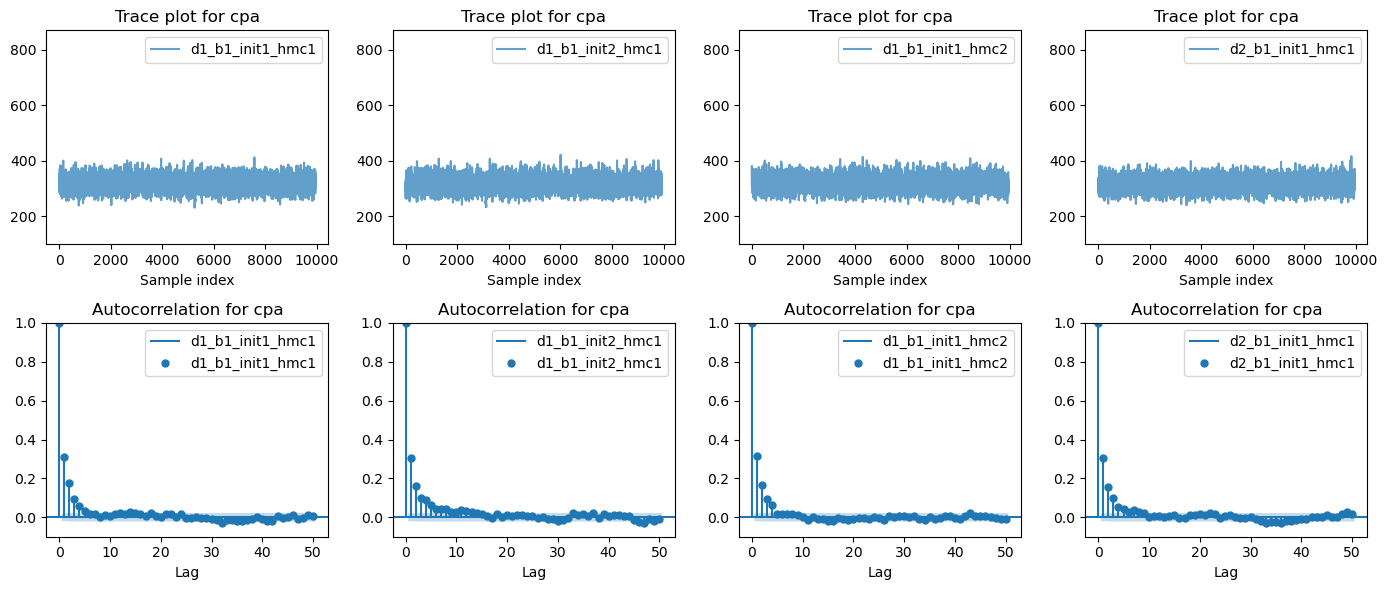

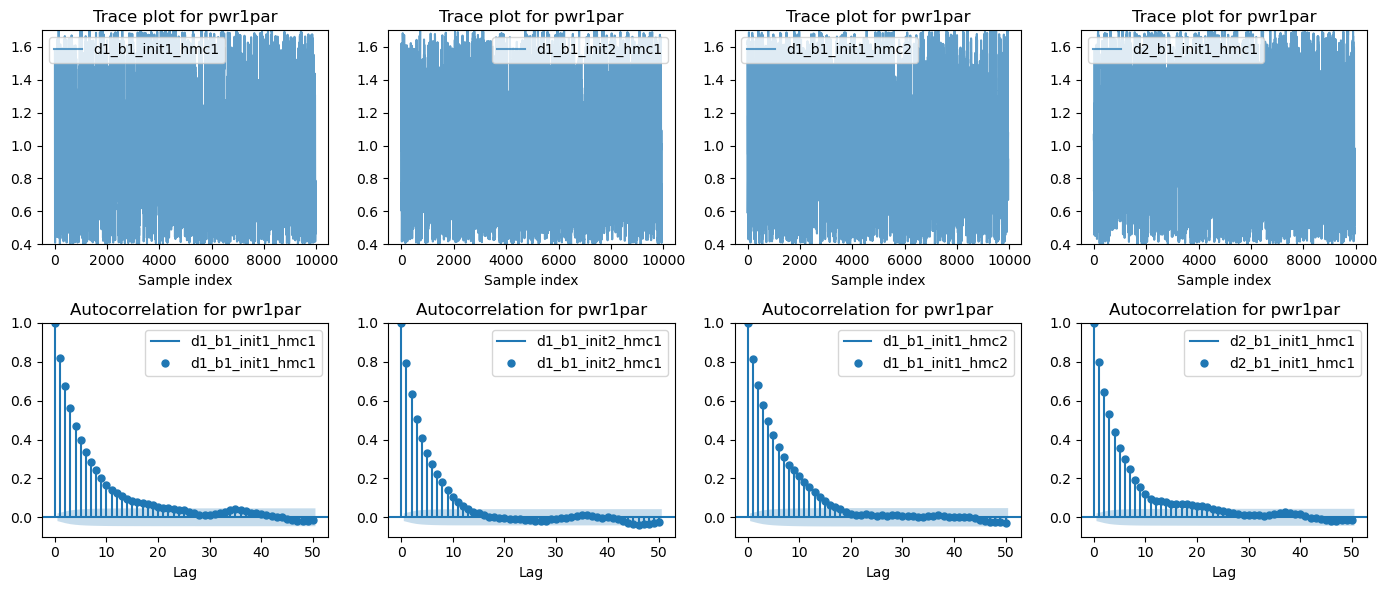

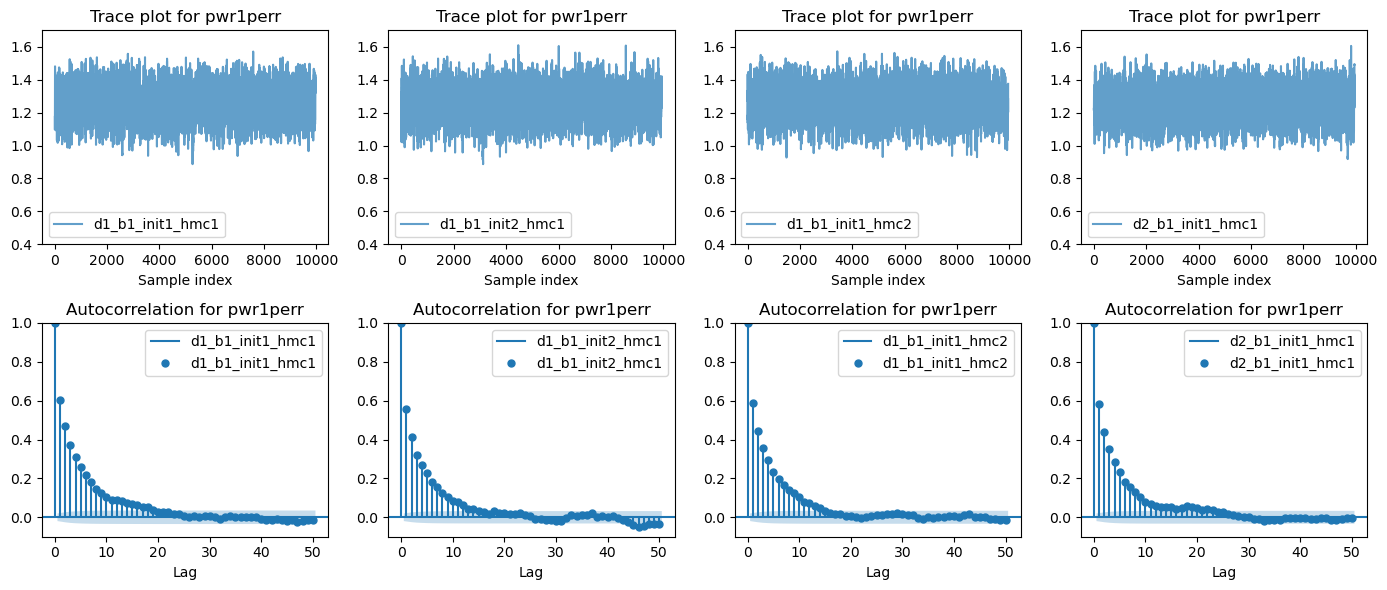

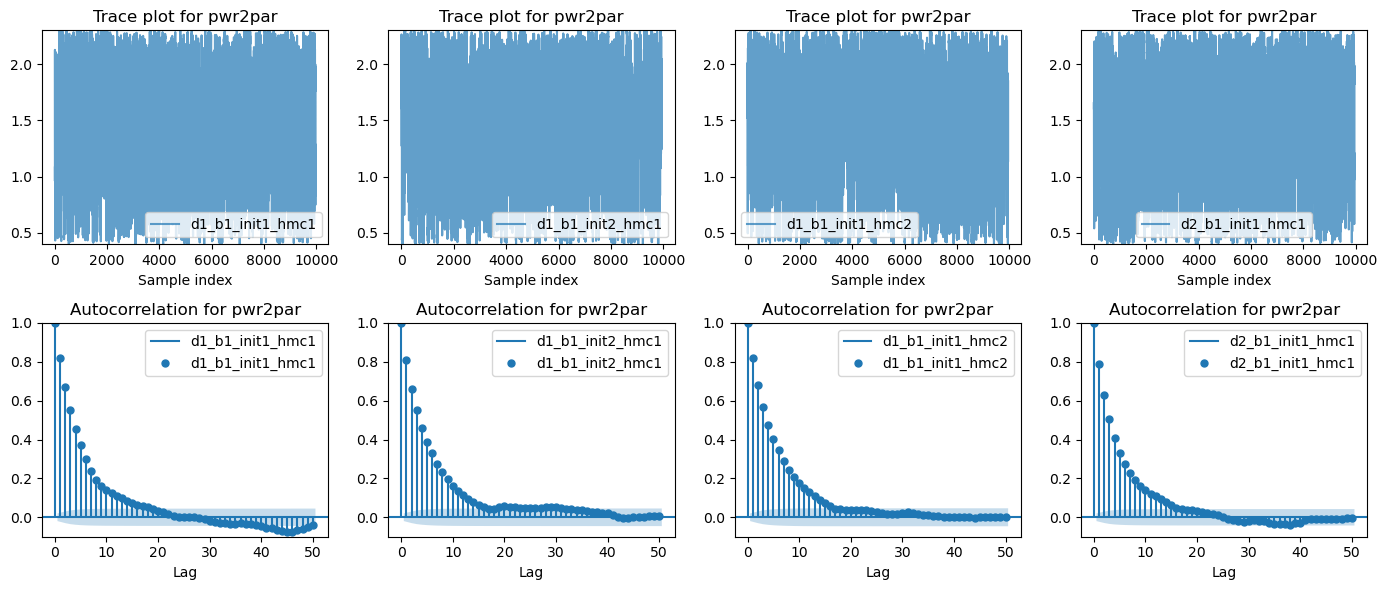

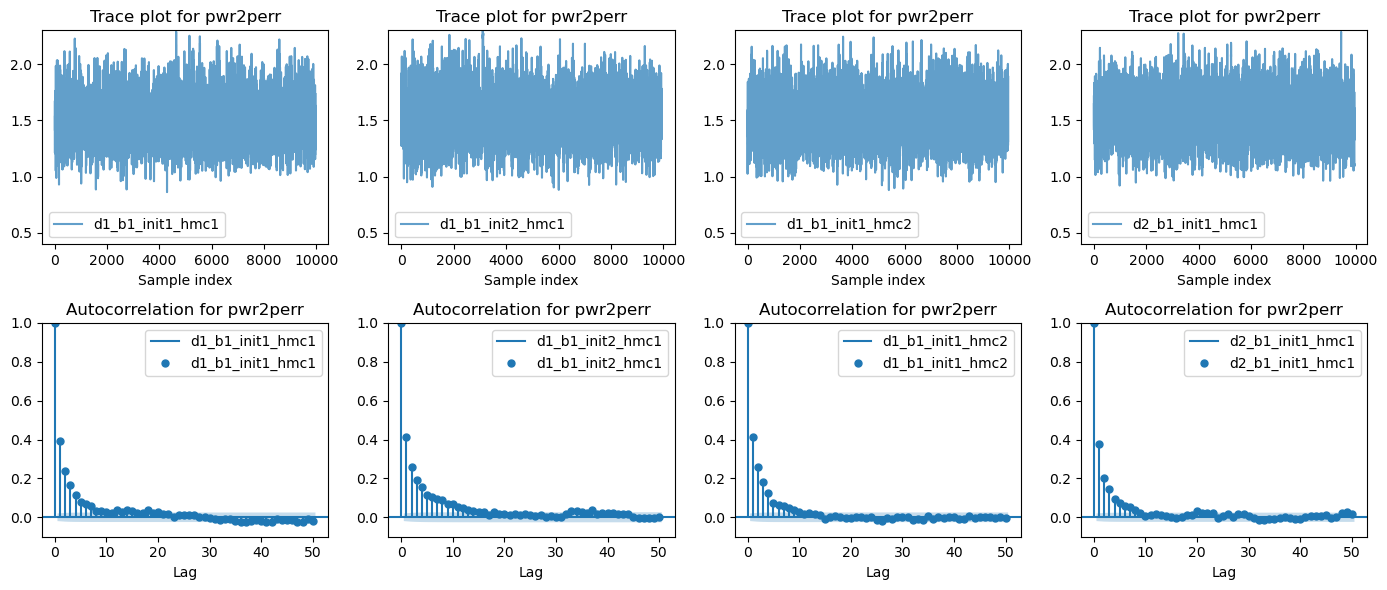

In [57]:
data_version=['d1', 'd2', 'd3', 'd4', 'd5'] 
model_version=['init1', 'init2', 'init3', 'init4', 'init5'] 
bootstrap=['b0', 'b1'] # 'b0' or 'b1', false or true
hmc_run = ['hmc1', 'hmc2'] # 'hmc1' or 'hmc2'

# Parameters (change me!)
idx = 131 # 24 corresponds to 20130221-20130319, the interval in the paper
train_size_fraction = 0.9
hmc_version='v34_trial5_test'
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"
data_bootstrap_model_hmc_identifier_3 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"

# Load relevant HMC results
results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"

# Make plots folder if it doesn't exist
plots_dir = Path(f'../../../results/{hmc_version}/plots/')
plots_dir.mkdir(parents=True, exist_ok=True)

# Get interval corresponding to one in paper
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]
print(f"Interval {interval} corresponds to index {idx} for {polarity} polarity in {exp_name}.")
df_int.head()

# Load the samples from each hmc run
# They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
# csv file has no headers, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')

PARAMETERS = ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
hmc_0_samples.columns = PARAMETERS
hmc_1_samples.columns = PARAMETERS
hmc_2_samples.columns = PARAMETERS
hmc_3_samples.columns = PARAMETERS

# For each parameter, plot the trace and the autocorrelation function for each HMC run
for param in PARAMETERS:
    # fig, axs = plt.subplots(2, 1, figsize=(8, 6))
    # axs[0].plot(hmc_0_samples[param], label=f'{data_bootstrap_model_hmc_identifier_0}', alpha=0.7)
    # axs[0].set_title(f'Trace plot for {param}')
    # axs[0].set_xlabel('Sample index')
    # axs[0].legend()
    fig, axs = plt.subplots(2, 4, figsize=(14, 6))
    axs[0][0].plot(hmc_0_samples[param], label=f'{data_bootstrap_model_hmc_identifier_0}', alpha=0.7)
    axs[0][1].plot(hmc_1_samples[param], label=f'{data_bootstrap_model_hmc_identifier_1}', alpha=0.7)
    axs[0][2].plot(hmc_2_samples[param], label=f'{data_bootstrap_model_hmc_identifier_2}', alpha=0.7)
    axs[0][3].plot(hmc_3_samples[param], label=f'{data_bootstrap_model_hmc_identifier_3}', alpha=0.7)
    for ax in axs[0]:
        ax.set_title(f'Trace plot for {param}')
        ax.set_xlabel('Sample index')
        ax.set_ylim(PARAMETERS_MIN[PARAMETERS.index(param)], PARAMETERS_MAX[PARAMETERS.index(param)])
        ax.legend()
    
    # plot_acf(hmc_0_samples[param], ax=axs[1], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_0}')
    # axs[1].set_xlabel('Lag')
    # axs[1].set_ylim(-0.1, 1.0)
    # axs[1].legend()
    plot_acf(hmc_0_samples[param], ax=axs[1][0], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_0}')
    plot_acf(hmc_1_samples[param], ax=axs[1][1], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_1}')
    plot_acf(hmc_2_samples[param], ax=axs[1][2], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_2}')
    plot_acf(hmc_3_samples[param], ax=axs[1][3], lags=50, title=f'Autocorrelation for {param}', label=f'{data_bootstrap_model_hmc_identifier_3}')
    for ax in axs[1]:
        ax.set_xlabel('Lag')
        ax.set_ylim(-0.1, 1.0)
        ax.legend()

    plt.tight_layout()
    plt.savefig(plots_dir / f'trace_acf_{param}_{polarity}_{train_size_fraction}_{idx}.png')
    plt.show()

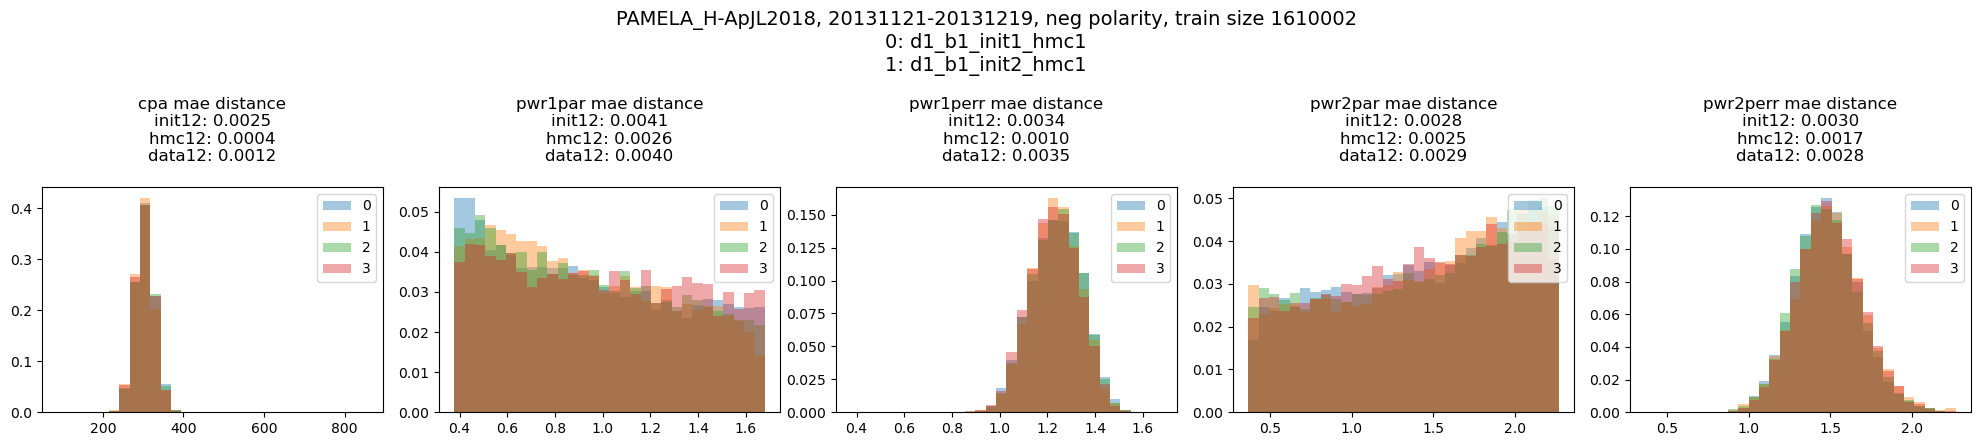

In [58]:
num_bins = 30
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Let's make a 1 x 5 grid of subplots, where they are the historograms of the samples. We'll plot both hmc_0 and hmc_1 samples in the same grid
fig, axs = plt.subplots(1, 5, figsize=(20, 4.5))
# plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\n0: {data_bootstrap_model_hmc_identifier_0}") #, 1: {data_bootstrap_model_hmc_identifier_1}\n2: {data_bootstrap_model_hmc_identifier_2}, 3: {data_bootstrap_model_hmc_identifier_3}", fontsize=14)
plt.suptitle(f"{exp_name}, {interval}, {polarity} polarity, train size {int(train_size_fraction * 1_788_892)}\n0: {data_bootstrap_model_hmc_identifier_0}\n1: {data_bootstrap_model_hmc_identifier_1}", fontsize=14)
# Plot the samples
distances = []
for i, param in enumerate(PARAMETERS):
    samples_0 = hmc_0_samples[param].values
    samples_1 = hmc_1_samples[param].values
    samples_2 = hmc_2_samples[param].values
    samples_3 = hmc_3_samples[param].values

    # Plot the samples with same bins
    # Use global binning after lab meeting conversation 4/9/2025
    min = PARAMETERS_MIN[i] 
    max = PARAMETERS_MAX[i]

    # Create histograms and plot
    hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
    hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
    hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
    hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)

    # Normalize the histograms
    hist_0 /= hist_0.sum()
    hist_1 /= hist_1.sum()
    hist_2 /= hist_2.sum()
    hist_3 /= hist_3.sum()

    # Compute distance as MAE between bins
    distance_01 = get_distance(hist_0, hist_1, metric)
    distance_02 = get_distance(hist_0, hist_2, metric)
    distance_03 = get_distance(hist_0, hist_3, metric)

    # Plot the histograms
    axs[i].bar(bins[:-1], hist_0, width=(bins[1]-bins[0]), alpha=0.4, label='0')
    axs[i].bar(bins[:-1], hist_1, width=(bins[1]-bins[0]), alpha=0.4, label='1')
    axs[i].bar(bins[:-1], hist_2, width=(bins[1]-bins[0]), alpha=0.4, label='2')
    axs[i].bar(bins[:-1], hist_3, width=(bins[1]-bins[0]), alpha=0.4, label='3')

    # Set the title and labels
    axs[i].set_title(f"{param} {metric} distance\ninit12: {distance_01:.4f}\nhmc12: {distance_02:.4f}\ndata12: {distance_03:.4f}\n")
    axs[i].legend(loc='upper right')

plt.tight_layout()
# plt.savefig(plots_dir / f'{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}_{idx}_samples.png', dpi=300)
plt.savefig(plots_dir / f'{data_bootstrap_model_hmc_identifier_0}_vs_all_{train_size_fraction}_{idx}_samples.png', dpi=300)
plt.show()

In [59]:
# Calculate Gelman-Rubin R-hat statistic for each parameter
chains_samples = [hmc_0_samples, hmc_1_samples , hmc_2_samples, hmc_3_samples]
rhats = compute_rhat(chains_samples, params=PARAMETERS, mode='split', thin=1, return_details=True)
print(rhats)
print("R-hat statistics:")
for param, rhat in rhats.items():
    if isinstance(rhat, tuple):
        rhat_value, details = rhat
        print(f"  {param}: {rhat_value:.4f} (details: m={details['m']}, n={details['n']}, rhat_classic={details['rhat_classic_equivalent']:.4f})")
    else:
        print(f"  {param}: {rhat:.4f}")

{'cpa': (1.0007662636779886, {'m': 8, 'n': 4968, 'theta_bar_j': array([318.18048498, 318.00148956, 315.68331296, 316.18024126,
       318.13846751, 317.9259522 , 316.77419713, 316.61612786]), 'sigma2_theta_j': array([565.03658951, 579.31542749, 606.8928768 , 528.6499596 ,
       577.62533801, 569.73715511, 554.08822039, 547.29984941]), 'theta_barbar': 317.18753418100823, 'sigma2_bar_theta': 566.0806770386, 'sigma2_theta_bar': 0.9818118890732374, 'B_j': 0.8678665031959024, 'W': 566.0806770386, 'B': 4877.641464915843, 'var_plus': 566.948543541796, 'rhat_equation_form': 1.0007662636779886, 'rhat_classic_equivalent': 1.0007662636779888}), 'pwr1par': (1.0019351778155712, {'m': 8, 'n': 4968, 'theta_bar_j': array([0.98841176, 0.95623273, 0.9609988 , 0.9599681 , 0.97076481,
       0.96734988, 1.02220291, 1.00328029]), 'sigma2_theta_j': array([0.14743695, 0.14231966, 0.12861221, 0.13218234, 0.13373422,
       0.14041504, 0.14206035, 0.14143317]), 'theta_barbar': 0.9786511593619767, 'sigma2_bar_

## All the train sizes

In [ ]:
# Parameters (change me!)
hmc_version='v32'
idx = 61 # 24 corresponds to 20130221-20130319, the interval in the paper
num_bins = 30
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'
train_fractions = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_2 = f"{data_version[0]}_{bootstrap[1]}_{model_version[1]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_3 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[1]}"

# Get values
df = index_mcmc_runs(file_version='2023')
df_int = df.iloc[idx:idx+1].copy(deep=True)
interval = df_int.interval.iloc[0]
polarity = df_int.polarity.iloc[0]
exp_name = df_int.experiment_name.iloc[0]

existing_train_fractions = []
distances_01 = {}
distances_02 = {}
distances_03 = {}
for param in PARAMETERS:
    distances_01[param] = []
    distances_02[param] = []
    distances_03[param] = []

# Calculate the distance for each parameter and train size
for i, train_size_fraction in enumerate(train_fractions):
    # Parameters (change me!)
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"
    results_dir_hmc_2 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_2}_{train_size_fraction}/"
    results_dir_hmc_3 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_3}_{train_size_fraction}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    try:
        hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
        hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
        hmc_2_samples = pd.read_csv(f'{results_dir_hmc_2}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
        hmc_3_samples = pd.read_csv(f'{results_dir_hmc_3}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    except FileNotFoundError as e:
        print(f"File not found for train size fraction {train_size_fraction}: {e}")
        continue

    existing_train_fractions.append(train_size_fraction)

    hmc_0_samples.columns = PARAMETERS
    hmc_1_samples.columns = PARAMETERS
    hmc_2_samples.columns = PARAMETERS
    hmc_3_samples.columns = PARAMETERS

    for j, param in enumerate(PARAMETERS):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values
        samples_2 = hmc_2_samples[param].values
        samples_3 = hmc_3_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)
        hist_2, bins = np.histogram(samples_2, bins=num_bins, range=(min, max), density=True)
        hist_3, bins = np.histogram(samples_3, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()
        hist_2 /= hist_2.sum()
        hist_3 /= hist_3.sum()

        # Calculate distance as MAE between bins
        distance_01 = get_distance(hist_0, hist_1, metric)
        distance_02 = get_distance(hist_0, hist_2, metric)
        distance_03 = get_distance(hist_0, hist_3, metric)

        distances_01[param].append(distance_01)
        distances_02[param].append(distance_02)
        distances_03[param].append(distance_03)

File not found for train size fraction 0.2: [Errno 2] No such file or directory: '../../../results/v32/d2_b1_init1_hmc1_0.2/samples_61_PAMELA_H-ApJ2013_20070523-20070617_neg.csv'
File not found for train size fraction 0.6: [Errno 2] No such file or directory: '../../../results/v32/d2_b1_init1_hmc1_0.6/samples_61_PAMELA_H-ApJ2013_20070523-20070617_neg.csv'
File not found for train size fraction 0.7: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.7/samples_61_PAMELA_H-ApJ2013_20070523-20070617_neg.csv'
File not found for train size fraction 0.8: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc2_0.8/samples_61_PAMELA_H-ApJ2013_20070523-20070617_neg.csv'
File not found for train size fraction 0.9: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.9/samples_61_PAMELA_H-ApJ2013_20070523-20070617_neg.csv'
File not found for train size fraction 1.0: [Errno 2] No such file or directory: '../../../results/v32/d1

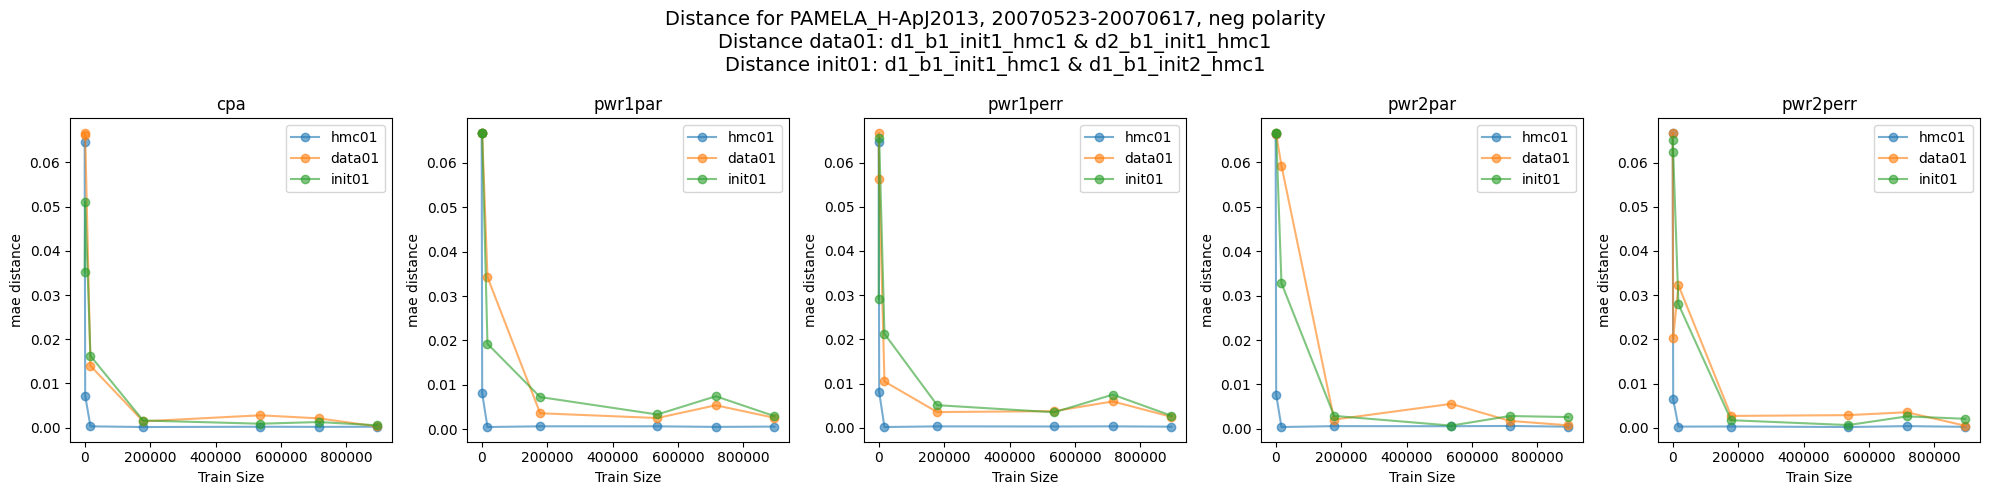

In [ ]:
# Let's make a 1 x 5 grid of subplots, where each plot is the distance metric for each parameter over all the train sizes
plt.figure(figsize=(20, 5))
# plt.suptitle(f"Distance for {exp_name}, {interval}, {polarity} polarity\nDistance hmc01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_3}\nDistance data01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_1}\nDistance init01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_2}", fontsize=14)
plt.suptitle(f"Distance for {exp_name}, {interval}, {polarity} polarity\nDistance data01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_1}\nDistance init01: {data_bootstrap_model_hmc_identifier_0} & {data_bootstrap_model_hmc_identifier_2}", fontsize=14)
data_train_fractions = np.array(existing_train_fractions) * 1_788_892 # Scale to the number of data points in the full dataset

# Plot the KL divergences
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    plt.plot(data_train_fractions, distances_03[param], marker='o', alpha=0.6, label='hmc01')
    plt.plot(data_train_fractions, distances_01[param], marker='o', alpha=0.6, label='data01')
    plt.plot(data_train_fractions, distances_02[param], marker='o', alpha=0.6, label='init01')
    plt.title(param)
    plt.xlabel('Train Size')
    plt.ylabel(f'{metric} distance')
    plt.legend()

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_all_{idx}_{metric}_distance.png', dpi=300)
plt.show()

## All the runs

In [ ]:
# Parameters (change me!)
data_bootstrap_model_hmc_identifier_0 = f"{data_version[0]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
data_bootstrap_model_hmc_identifier_1 = f"{data_version[1]}_{bootstrap[1]}_{model_version[0]}_{hmc_run[0]}"
train_size_fraction = 0.8
num_bins = 30
hmc_version = 'v32'
metric = 'mae' # 'mae', 'mse', 'kl', or 'wasserstein'

# Get values
df_idxs = range(len(df))
existing_df_idxs = []
distances = {}
for param in PARAMETERS:
    distances[param] = []

# Calculate the distance for each parameter and train size
for i, idx in enumerate(df_idxs):
    # Parameters (change me!)
    results_dir_hmc_0 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_0}_{train_size_fraction}/"
    results_dir_hmc_1 = f"../../../results/{hmc_version}/{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}/"

    # Load the samples from each hmc run
    # They are stored like this: f'{results_dir_hmc}.0/samples_{idx}_{df.experiment_name}_{df.interval}_{df.polarity}.csv'
    # csv file has no headersd, but samples are in this order: ['cpa', 'pwr1par', 'pwr1perr', 'pwr2par', 'pwr2perr']
    exp_name = df.experiment_name.iloc[idx]
    interval = df.interval.iloc[idx]
    polarity = df.polarity.iloc[idx]
    try:
        hmc_0_samples = pd.read_csv(f'{results_dir_hmc_0}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
        hmc_1_samples = pd.read_csv(f'{results_dir_hmc_1}samples_{idx}_{exp_name}_{interval}_{polarity}.csv', header=None, delimiter=',')
    except FileNotFoundError as e:
        print(f"File not found for index {idx}: {e}")
        continue

    existing_df_idxs.append(idx)
    hmc_0_samples.columns = PARAMETERS
    hmc_1_samples.columns = PARAMETERS

    for j, param in enumerate(PARAMETERS):
        samples_0 = hmc_0_samples[param].values
        samples_1 = hmc_1_samples[param].values

        # Plot the samples with same bins
        # Use global binning after lab meeting conversation 4/9/2025
        min = PARAMETERS_MIN[j] 
        max = PARAMETERS_MAX[j]

        # Create histograms and plot
        hist_0, bins = np.histogram(samples_0, bins=num_bins, range=(min, max), density=True)
        hist_1, bins = np.histogram(samples_1, bins=num_bins, range=(min, max), density=True)

        # Normalize the histograms
        hist_0 /= hist_0.sum()
        hist_1 /= hist_1.sum()

        # Calculate distance as MAE between bins
        distance = get_distance(hist_0, hist_1, metric)
        distances[param].append(distance)

File not found for index 0: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.8/samples_0_AMS02_H-PRL2021_20110520-20110610_neg.csv'
File not found for index 1: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.8/samples_1_AMS02_H-PRL2021_20110611-20110707_neg.csv'
File not found for index 2: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.8/samples_2_AMS02_H-PRL2021_20110708-20110803_neg.csv'
File not found for index 3: [Errno 2] No such file or directory: '../../../results/v32/d2_b1_init1_hmc1_0.8/samples_3_AMS02_H-PRL2021_20110804-20110830_neg.csv'
File not found for index 4: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.8/samples_4_AMS02_H-PRL2021_20110831-20110926_neg.csv'
File not found for index 5: [Errno 2] No such file or directory: '../../../results/v32/d1_b1_init1_hmc1_0.8/samples_5_AMS02_H-PRL2021_20110927-20111023_neg.csv'
File not found for index 6: [Errno

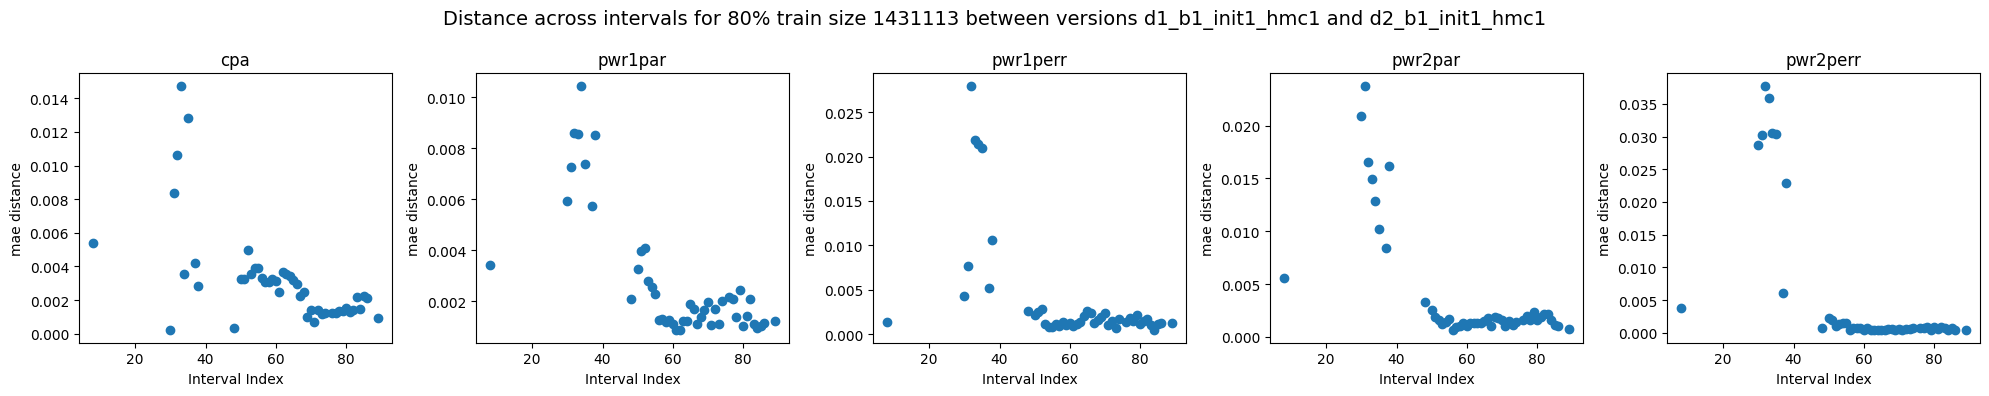

In [ ]:
# Let's make a 1 x 5 grid of subplots, where each plot is the kl_divergence for each parameter over all the train sizes
plt.figure(figsize=(20, 4))
plt.suptitle(f"Distance across intervals for {int(train_size_fraction * 100)}% train size {int(train_size_fraction * 1_788_892)} between versions {data_bootstrap_model_hmc_identifier_0} and {data_bootstrap_model_hmc_identifier_1}", fontsize=14)

# Plot the KL divergences
for i, param in enumerate(PARAMETERS):
    plt.subplot(1, 5, i+1)
    plt.scatter(existing_df_idxs, distances[param], marker='o')
    plt.title(param)
    plt.xlabel('Interval Index')
    plt.ylabel(f'{metric} distance')

plt.tight_layout()
plt.savefig(f'../../../results/{hmc_version}/plots/{data_bootstrap_model_hmc_identifier_0}_vs_{data_bootstrap_model_hmc_identifier_1}_{train_size_fraction}_{metric}_distance.png', dpi=300)
plt.show()